In [1]:
%load_ext autoreload

In [2]:
%autoreload 3

In [2]:
import sys
sys.path.append('../')

In [3]:
import os,glob,cv2
from matplotlib import pyplot as plt
import numpy as np

In [4]:
from detectors import SddCxxDRD, SddCxxLPD, SddCxxPSD
from detectors import DRDParameter, LPDParameter, PSDParameter

In [5]:
def to_grayscale_heatmap(
    anomaly_img: np.ndarray
) -> np.ndarray:
    denom = anomaly_img.max()
    if denom == 0:
        hm = np.zeros_like(anomaly_img, dtype = np.uint8)
        return hm
    else:
        scale = 2**8 / denom
        hm = scale * anomaly_img
        hm[hm < 0] = 0
        hm[hm > 2**8 - 1] = 2**8 - 1
        return hm.astype(np.uint8)

def to_overlap_img(
    bg: np.ndarray,
    anomaly_img: np.ndarray
) -> np.ndarray:
    tmp = to_grayscale_heatmap(anomaly_img = anomaly_img)
    hm = cv2.applyColorMap(tmp, cv2.COLORMAP_JET)
    mode = np.argmax(np.bincount(tmp.flatten()))
    hm[tmp <= mode + 5] = 0 # FIXME: Consider better way instead of mode + 5.
    if (len(bg.shape) == 2):
        bg = cv2.cvtColor(bg, cv2.COLOR_GRAY2BGR)
    overlap_img = cv2.addWeighted(bg, 1.0, hm, 0.7, 0)
    return overlap_img

# DRD

In [7]:
sdd_parameter = DRDParameter()
sdd_parameter.patch_size_height = 16
sdd_parameter.patch_size_width = 16
sdd_parameter.extraction_step_height = 8
sdd_parameter.extraction_step_height = 8
sdd_parameter.train_size = -1
sdd_parameter.b_acd = True

In [8]:
drd = SddCxxDRD(sdd_parameter)

In [9]:
woodblockpath = glob.glob('../data/preprocessed_wood_block/train/*jpg')
woodblockdata = [cv2.imread(i) for i in woodblockpath]
woodblocktestpath = glob.glob('../data/preprocessed_wood_block/test/NG/*jpg')
woodblocktestdata = [cv2.imread(i) for i in woodblocktestpath]

In [10]:
# check empty
if len(woodblockdata) == 0:
    print('woodblockdata is empty')

In [11]:
woodblock_train_mask = []
woodblock_test_mask = []
for img in woodblockdata:
    mask = np.ones_like(img[:,:,0], dtype=np.uint8)
    mask[50:-50, 50:-50] = 0
    woodblock_train_mask.append(mask)
for img in woodblocktestdata:
    mask = np.ones_like(img[:,:,0], dtype=np.uint8)
    mask[200:-200, 400:600] = 0
    woodblock_test_mask.append(mask)

In [12]:
drd.fit(woodblockdata)
# update license

In [37]:
anomaly_imgs = drd.predict(woodblocktestdata)

In [38]:
overlap_imgs = [to_overlap_img(i, j) for (i, j) in zip(woodblocktestdata, anomaly_imgs)]

In [39]:
print(woodblocktestdata)

[array([[[ 59,  80,  77],
        [ 60,  81,  78],
        [ 59,  80,  78],
        ...,
        [ 92, 115, 110],
        [ 92, 115, 110],
        [ 91, 114, 109]],

       [[ 58,  79,  76],
        [ 59,  80,  77],
        [ 58,  79,  77],
        ...,
        [ 96, 119, 114],
        [ 95, 118, 113],
        [ 93, 116, 111]],

       [[ 56,  77,  75],
        [ 57,  78,  76],
        [ 57,  78,  76],
        ...,
        [ 94, 120, 114],
        [ 93, 119, 113],
        [ 91, 117, 111]],

       ...,

       [[ 77,  95,  94],
        [ 75,  96,  93],
        [ 77,  95,  94],
        ...,
        [139, 171, 160],
        [143, 176, 162],
        [142, 175, 161]],

       [[ 76,  97,  94],
        [ 77, 100,  95],
        [ 78,  99,  96],
        ...,
        [142, 172, 161],
        [143, 173, 162],
        [142, 172, 161]],

       [[ 77, 100,  95],
        [ 79, 102,  97],
        [ 80, 103,  98],
        ...,
        [140, 170, 159],
        [140, 170, 159],
        [138, 168, 157]

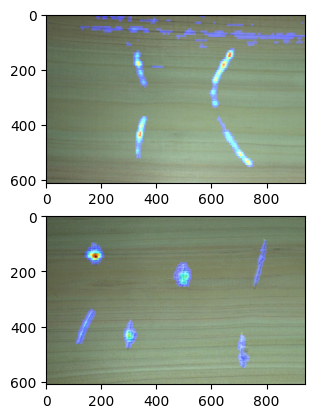

In [40]:
fig, axis = plt.subplots(2, 1)
for ax, img in zip(axis, overlap_imgs):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [15]:
#mask

In [16]:
drd.fit(woodblockdata, woodblock_train_mask)

In [17]:
anomaly_imgs = drd.predict(woodblocktestdata, woodblock_test_mask)

In [18]:
overlap_imgs = [to_overlap_img(i, j) for (i, j) in zip(woodblocktestdata, anomaly_imgs)]

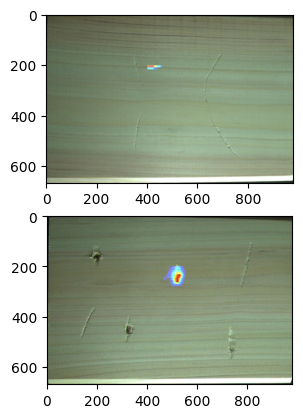

In [19]:
fig, axis = plt.subplots(2, 1)
for ax, img in zip(axis, overlap_imgs):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# LPD

In [20]:
sdd_parameter = LPDParameter()
sdd_parameter.patch_size_height = 16
sdd_parameter.patch_size_width = 16
sdd_parameter.extraction_step_height = 4
sdd_parameter.extraction_step_height = 4

In [21]:
lpd = SddCxxLPD(sdd_parameter)

In [22]:
raspberry_pi_path = ['../data/raspberry_pi/train/ok_0_train.png', 
                     '../data/raspberry_pi/train/ok_9_train.png']
raspberry_pi_data = [cv2.imread(i) for i in raspberry_pi_path]
raspberry_pi_testpath = ['../data/raspberry_pi/test/OK/ok_1_test.png', 
                         '../data/raspberry_pi/test/NG/ng_0.png']
raspberry_pi_testdata = [cv2.imread(i) for i in raspberry_pi_testpath]
raspberry_pi_testdata_gray = [cv2.imread(i, 0) for i in raspberry_pi_testpath]

In [23]:
raspberry_pi_train_mask = []
raspberry_pi_test_mask = []
for img in raspberry_pi_data:
    mask = np.ones_like(img[:,:,0], dtype=np.uint8)
    mask[50:-50, 50:-50] = 0
    raspberry_pi_train_mask.append(mask)
for img in raspberry_pi_testdata:
    mask = np.ones_like(img[:,:,0], dtype=np.uint8)
    mask[200:-200, 400:600] = 0
    raspberry_pi_test_mask.append(mask)

In [24]:
lpd.fit(raspberry_pi_data)

In [25]:
anomaly_imgs = lpd.predict(raspberry_pi_testdata)

In [26]:
overlap_imgs = [to_overlap_img(i, j) for (i, j) in zip(raspberry_pi_testdata_gray, anomaly_imgs)]

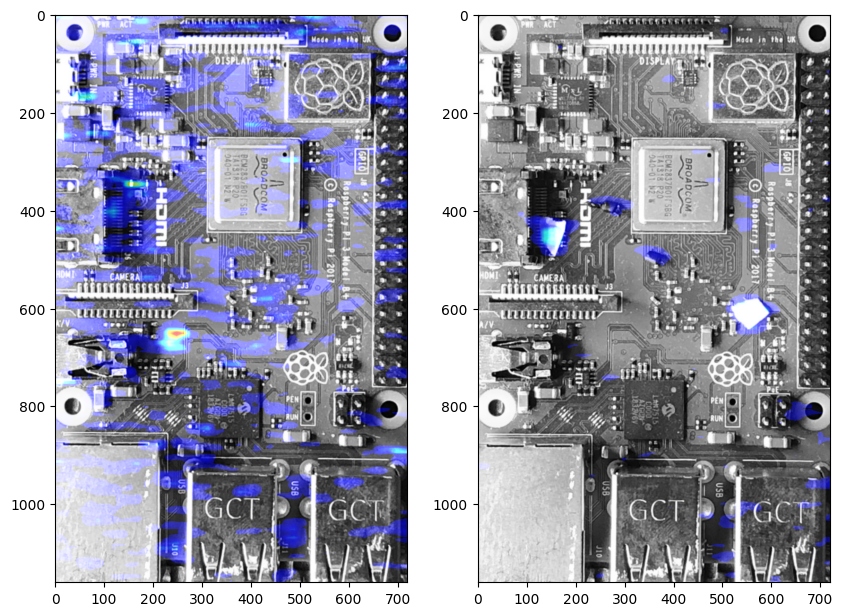

In [27]:
fig, axis = plt.subplots(1, 2, figsize=(10,30))
for ax, img in zip(axis, overlap_imgs):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [28]:
#mask

In [29]:
lpd.fit(raspberry_pi_data, raspberry_pi_train_mask)

In [30]:
anomaly_imgs = lpd.predict(raspberry_pi_testdata, raspberry_pi_test_mask)

In [31]:
overlap_imgs = [to_overlap_img(i, j) for (i, j) in zip(raspberry_pi_testdata_gray, anomaly_imgs)]

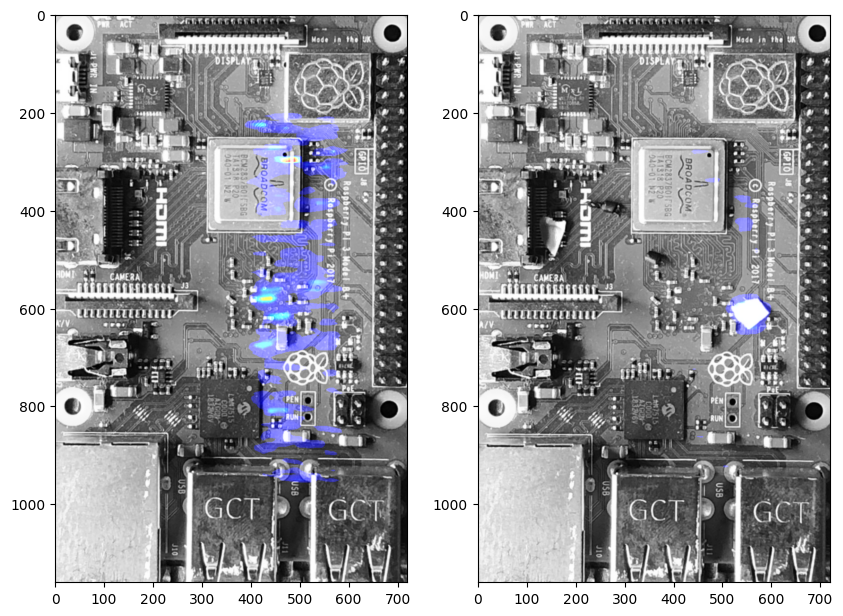

In [32]:
fig, axis = plt.subplots(1, 2, figsize=(10,30))
for ax, img in zip(axis, overlap_imgs):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# PSD

In [6]:
raspberry_pi_path = ['../data/raspberry_pi/train/ok_0_train.png', 
                     '../data/raspberry_pi/train/ok_9_train.png']
raspberry_pi_data = [cv2.imread(i) for i in raspberry_pi_path]
raspberry_pi_testpath = ['../data/raspberry_pi/test/OK/ok_1_test.png', 
                         '../data/raspberry_pi/test/NG/ng_0.png']
raspberry_pi_testdata = [cv2.imread(i) for i in raspberry_pi_testpath]
raspberry_pi_testdata_gray = [cv2.imread(i, 0) for i in raspberry_pi_testpath]

In [7]:
raspberry_pi_train_mask = []
raspberry_pi_test_mask = []
for img in raspberry_pi_data:
    mask = np.ones_like(img[:,:,0], dtype=np.uint8)
    mask[50:-50, 50:-50] = 0
    raspberry_pi_train_mask.append(mask)
for img in raspberry_pi_testdata:
    mask = np.ones_like(img[:,:,0], dtype=np.uint8)
    mask[200:-200, 400:600] = 0
    raspberry_pi_test_mask.append(mask)

In [1]:
sdd_parameter = PSDParameter()
sdd_parameter.b_soe = True
sdd_parameter.b_aer = False
sdd_parameter.onnx = '../distfiles/wide_resnet50_2.onnx'
sdd_parameter.names = ('356', '398', '460')
sdd_parameter.onnx = '../distfiles/resnet18.onnx'
sdd_parameter.names = ('140', '156', '172')

NameError: name 'PSDParameter' is not defined

In [9]:
sdd_parameter

PSDParameter(alg='PatchSampleDetector', license_path='../license/node-locked.lic', onnx='../distfiles/resnet18-5c106cde.onnx', names=('356', '398', '460'), n_features=112, ridge=0.01, r_growth=0.05, b_soe=True, b_aer=False)

In [10]:
psd = SddCxxPSD(sdd_parameter)

In [11]:
psd.fit(raspberry_pi_data)

RuntimeError: OpenCV(4.6.0) c:\build\master_winpack-build-win64-vc15\opencv\modules\dnn\src\net_impl.cpp:280: error: (-204:Requested object was not found) Layer with requested id=-1 not found in function 'cv::dnn::dnn4_v20220524::Net::Impl::getLayerData'


In [43]:
anomaly_imgs = psd.predict(raspberry_pi_testdata)

In [44]:
from ext import (
    SddCxxSensitivity,
    SddCxxRectangleList,
    SddCxxRectangleLists,
    SddCxxLabelList,
    SddCxxAnomalyList,
)

In [48]:
scs = SddCxxSensitivity()
scs.sen.anomaly = .1
scs.sen.area = 100
rects = SddCxxRectangleLists()
labels = SddCxxLabelList()
anomalys = SddCxxAnomalyList()
psd.interpret(
    scs=scs,
    anomaly_imgs=anomaly_imgs,
    rects=rects,
    labels=labels,
    anomalys=anomalys,
)

In [52]:
[img.max() for img in anomaly_imgs]

[0.20858192443847656, 0.48478662967681885]

In [49]:
anomalys

SddCxxAnomalyList[0.208582, 0.484787]

In [38]:
overlap_imgs = [to_overlap_img(i, j) for (i, j) in zip(raspberry_pi_testdata_gray, anomaly_imgs)]

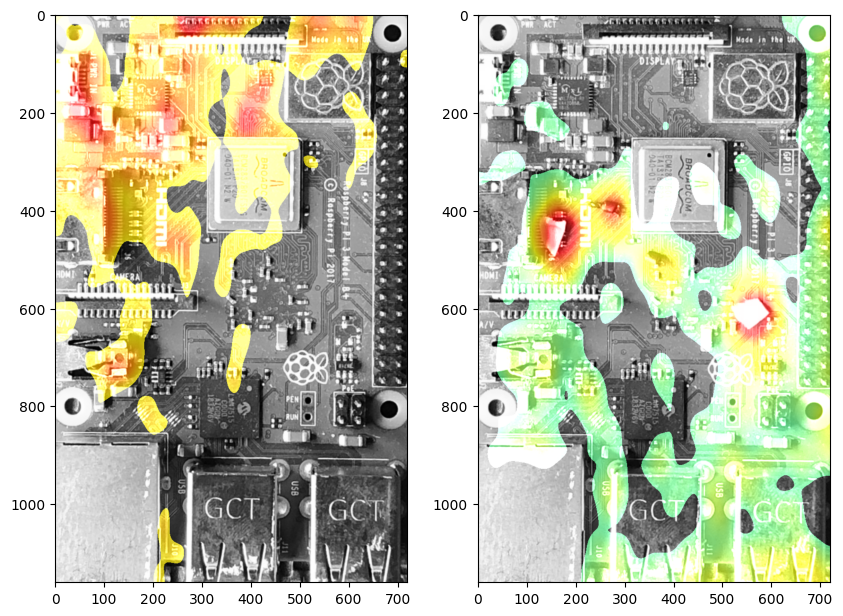

In [39]:
fig, axis = plt.subplots(1, 2, figsize=(10,30))
for ax, img in zip(axis, overlap_imgs):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))